In [1]:
import networkx as nx

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import polars as pl

from importlib import reload

In [7]:
nodes_info=pd.read_parquet("nodes_info_simply170k.pq")

edgelist = pd.read_parquet("net_simple_170k_edgelist.parq")
edgelist["i"] = edgelist["i"].apply(lambda x: f"osm{x}")
edgelist["j"] = edgelist["j"].apply(lambda x: f"osm{x}")

nodes_resort = nodes_info.sort_values(["x","y"]).reset_index()[["y","x","i"]]
nodes_resort["i"]=nodes_resort.i.apply(lambda x: f"osm{x}")

nodes_resort

,y,x,i
0,45.001378,7.458301,osm558503091
1,45.080493,7.458309,osm4254159242
2,44.973242,7.458309,osm748859908
3,44.904150,7.458310,osm473197569
4,44.985260,7.458312,osm2003119842
...,...,...,...
174766,44.989321,7.874476,osm6273099414
174767,44.915537,7.874478,osm1629797619
174768,45.157194,7.874478,osm2108620238
174769,45.057161,7.874479,osm2906849298


In [3]:
WEB_MERCATOR="EPSG:3857"
LATLNG="EPSG:4326"

In [4]:
from gtfsisochrones import graph

import rustworkx as rx

In [18]:
nrx,nodes_df, gnodes_i = graph.build_graph_rx(nodes_resort, edgelist)

In [11]:
inodes = {v:k for k,v in gnodes_i.items()}

In [12]:
NNODES=len(inodes)

### Build KDTree

In [13]:
from scipy.spatial import KDTree

import geopandas as gpd

import shapely as sh

In [14]:
stops = pd.read_parquet("stops_filter.pq")
stops=stops[["stop_id","stop_code","stop_lat","stop_lon","stop_name"]].sort_values("stop_id")

In [19]:
stops_geo=gpd.GeoDataFrame(stops,geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),crs="EPSG:4326").to_crs("EPSG:3857")

nodes_geo = gpd.GeoDataFrame(nodes_resort,geometry=gpd.points_from_xy(nodes_resort.x, nodes_resort.y),crs="EPSG:4326").to_crs("EPSG:3857")

nodes_by_idex = pd.Series(inodes)

points_xy = np.array([(p.x,p.y) for p in nodes_geo["geometry"]])

stops_xy = np.array([(p.x,p.y) for p in stops_geo["geometry"]])

kdtree = KDTree(points_xy)

dists, inn = kdtree.query(stops_xy,2)

stops_ids=stops_geo.stop_id.values

stop_gids, stopid_remove, nnod,nedg=graph.add_stops_nodes_rx(nrx,stops_ids,dists,inn,maxdist=1200)

stops_df = graph.adjust_stops_graph(stops, stop_gids, stopid_remove)

NNODES=len(nrx.nodes())

In [20]:
stop_id_gid = [stops_df[k].values for k in ["stop_id","graph_i"]]

In [ ]:
stops_df

In [ ]:
gid_for_stop=dict(zip(*stop_id_gid))

In [21]:
stops_df["is_metro"] = stops_df.stop_name.str.contains("METRO")
stops_metro = {id: m for id,m in zip(stops_df.stop_id, stops_df.is_metro)}

nodes_all = nodes_resort.copy()
nodes_all["is_stop"] = False

ss=stops_df[["stop_code","stop_lon","stop_lat","graph_i"]].rename(columns=dict(stop_code="i",stop_lon="x",stop_lat="y",graph_i="ig"))
ss["is_stop"]=True
nodes_all = pd.concat([nodes_all, ss],ignore_index=True)

In [ ]:
import gc
gc.collect()

In [ ]:
len(stops_df.graph_i)

#### precompute the distances on the stops

In [22]:
def find_distance_graph(inp):
    nrx, gid, nnodes = inp
    cost = lambda x: x["d"]
    r=rx.dijkstra_shortest_path_lengths(nrx,gid,graph.cost)
    d = np.empty(nnodes,dtype=np.uint16)
    d[gid]=0
    for i in range(nnodes):
        if i == gid:
            continue
        d[i] = int(r[i])
    return d

In [23]:
from multiprocessing.pool import Pool

In [24]:
from itertools import product

In [25]:
miter=(product([nrx],stops_df.graph_i,[NNODES]))

with Pool(6) as pool:
    distances = np.stack(tuple(pool.imap(find_distance_graph, miter, chunksize=100)))

In [26]:
distances.shape

(4239, 179010)

In [46]:
DIST_ARRAY = distances

In [47]:
DIST_IDCS = {k:i for i,k in enumerate(stops_df.stop_id)}

In [35]:
np.savez_compressed("distances_stopid.npz",distances=distances, stopsids=stops_df.stop_id.values)

## Load GTFS data

In [37]:
import polars as pl

import pyproj

crs_conv = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857",always_xy=True)
crs_back_conv = pyproj.Transformer.from_crs(WEB_MERCATOR, LATLNG,always_xy=True)

In [38]:
calendar = pl.read_parquet("calendar.parq")
calen_dates = pl.read_parquet("calendar_dates.parq")
stoptimes = pl.read_parquet("stoptimes_filter.pq")
stoptimes =stoptimes.sort("departure_time",)

gtfstrips=pl.read_parquet("trips.parq")

trips_metro=gtfstrips.filter(pl.col("route_id")=="METROU")["trip_id"]

In [39]:
from datetime import date

In [40]:
from gtfsisochrones import gtfstime as mti

from datetime import datetime,timedelta

In [41]:
#START_POINT=  45.06290453289125, 7.678363772115544
#START_POINT= 45.0826516142634, 7.624451806525321
START_POINT = 45.071347775989494, 7.684791243624913
ST1=list(reversed(START_POINT))
ST1

[7.684791243624913, 45.071347775989494]

More efficient version

In [ ]:
### START

### ALGORITHM

In [54]:
START_POINT

(45.071347775989494, 7.684791243624913)

In [43]:
SPEED_FOOT_KMH=5

START_DATE=date(2024,1,20)

trips_date = mti.get_trips_date(calendar, calen_dates, gtfstrips, trips_metro, START_DATE)

stoptimes_today = stoptimes.filter(pl.col("trip_id").is_in(trips_date["trip_id"]))

In [92]:
str(START_DATE),str(START_TIME)

('2024-01-20', '12:30:00')

In [ ]:
gid_for_stop

In [71]:
POINTS ={"castello": (45.071347775989494, 7.684791243624913),
         "portanuova":(45.06262925502989, 7.678864590826654),
         "piazzarivoli":(45.07507112777764, 7.643434491703672)
        }

In [97]:
START_TIME=mti.GtfsTime(12,30,0)
place="portanuova"
START_POINT = POINTS[place]

MAX_TIME_dt = timedelta(hours=1)


In [73]:
data_algo = {
    "stops_metro": stops_metro,
    "stop_id_gid":stop_id_gid,
    "num_nodes_graph": len(nrx.nodes()),
    ##distances
    "distances_g":DIST_ARRAY,
    "distances_idx_sid":DIST_IDCS,

    "speed_foot_kmh": 5,
    "delay_stop": 20, ##seconds
    "delay_metro_stop":60*3, ## 3 mins
    
    
}

In [74]:
data_algo.keys()

dict_keys(['stops_metro', 'stop_id_gid', 'num_nodes_graph', 'distances_g', 'distances_idx_sid', 'speed_foot_kmh', 'delay_stop', 'delay_metro_stop'])

In [75]:
import gtfsisochrones.isochrone as isocomp

In [76]:
reload(isocomp)

<module 'gtfsisochrones.isochrone' from '/home/fabio/pCloudDrive/projects/isochrones_exp/running/gtfsisochrones/isochrone.py'>

In [77]:
timetaken = isocomp.run_isochrone_algo(START_POINT, START_TIME, MAX_TIME_dt,nrx, kdtree, stoptimes_today, data_algo)

METRO: 3634 12:44:51
METRO: 3633 12:44:55
METRO: 3631 12:47:37
METRO: 3632 12:48:20
METRO: 3630 12:49:49
METRO: 3635 12:51:02
METRO: 3628 12:53:49
METRO: 3636 12:57:00
METRO: 3627 12:57:40
METRO: 3626 12:58:02
METRO: 3637 12:59:00
METRO: 3638 13:00:00
METRO: 3625 13:01:00
METRO: 3639 13:02:00
METRO: 3624 13:02:00
METRO: 3640 13:03:00
METRO: 3623 13:04:00
METRO: 8354 13:05:00
METRO: 3622 13:05:00
METRO: 8648 13:06:00
METRO: 3621 13:06:00
METRO: 3620 13:08:00
METRO: 3619 13:09:00


In [78]:
timetaken

array([9185.92, 8325.36, 9532.96, ..., 5085.64, 1771.28, 1908.84])

## PLOTTING

In [79]:
import pyproj
import contextily as cx
crs=pyproj.crs.CRS.from_user_input("EPSG:4326");

In [80]:
mask=(timetaken<=(60*5))
l=nodes_all[(mask)&(~nodes_all.is_stop)]

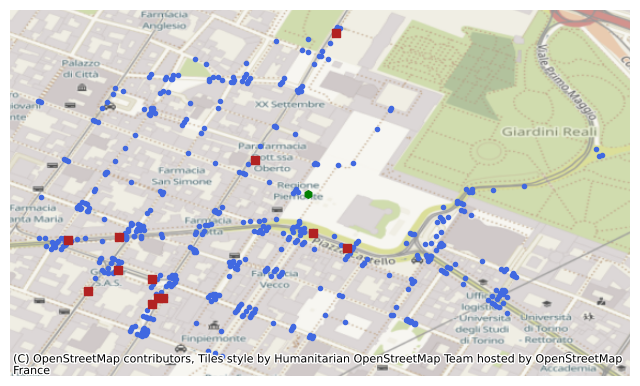

In [81]:
f,ax = plt.subplots(figsize=(8,8))

ax.scatter(l.x,l.y,color="royalblue",marker=".")

#for sc in [39,40,3582,253,3492]:
#st1=stops_df[stops_df.graph_i.isin(l["ig"])]
st1 = nodes_all[(mask)&(nodes_all.is_stop)]
#sl=stops[stops.stop_code==sc]
ax.scatter(st1.x,st1.y,color="firebrick",marker="s")

ax.scatter(*reversed(START_POINT), color="green",marker="h",s=30)


#ax.scatter(*reversed(START_POINT), color="red")
ax.axis("off")
cx.add_basemap(ax,crs=crs)

In [82]:
reload(isocomp)

<module 'gtfsisochrones.isochrone' from '/home/fabio/pCloudDrive/projects/isochrones_exp/running/gtfsisochrones/isochrone.py'>

In [84]:
layers_iso = [isocomp.make_layers_isochrone(timetaken,nodes_all,m,multipolygon=True) for m in [10,15,20,25,30,35,40,45,50]]

In [85]:
polygons=pd.concat(layers_iso,ignore_index=True)#.simplify(10)

In [ ]:
day

In [93]:
polygons.to_parquet(f"polygons_times_{place}_{str(START_DATE)}_{str(START_TIME)}.pq")

In [86]:
dfplot=polygons

In [87]:
dfplot = dfplot.sort_values("mins",ascending=False)

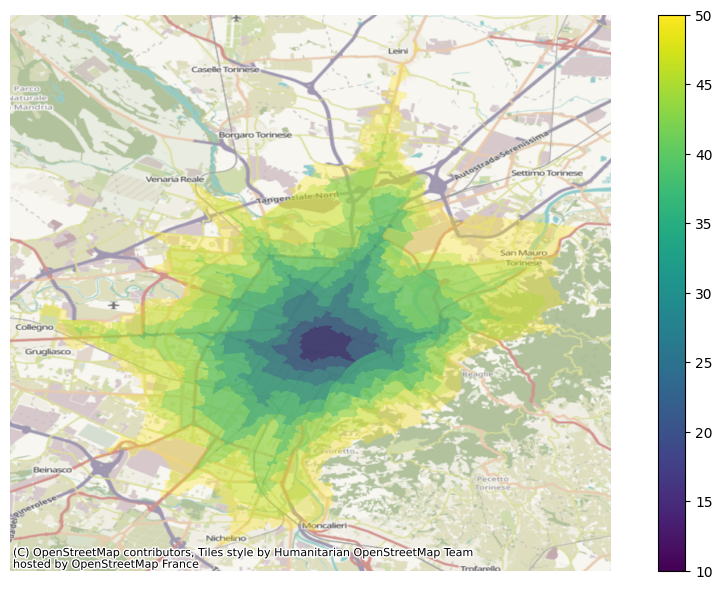

In [96]:
ax=dfplot.plot(column="mins",alpha=0.35, figsize=(9.8,6), legend=True)

ax.set_aspect("equal")
cx.add_basemap(ax, crs=dfplot.crs)
ax.axis("off")
plt.tight_layout()
#plt.legend(loc="lower left")

plt.savefig(f"isochrones_times_{place}_{str(START_DATE)}_{str(START_TIME)}.png",dpi=200,bbox_inches="tight")


In [106]:
(24-5)*3

57

## Do a sweep in the times

In [98]:
first_time = mti.GtfsTime(5,0,0)

In [253]:
all_times = [first_time+mti.GtfsTime(0,15*i,0) for i in range((25-5)*4+1)]

In [254]:
len(all_times)

81

In [255]:
all_times[-1]

GtfsTime(hours=25, minutes=0, seconds=0)

In [256]:
reload(isocomp)

<module 'gtfsisochrones.isochrone' from '/home/fabio/pCloudDrive/projects/isochrones_exp/running/gtfsisochrones/isochrone.py'>

In [257]:
POINTS ={"castello": (45.071347775989494, 7.684791243624913),
         "portanuova":(45.06262925502989, 7.678864590826654),
         "piazzarivoli":(45.07507112777764, 7.643434491703672)
        }

In [258]:
place="portanuova"
start_point = POINTS[place]

max_time_dt = timedelta(hours=1)


In [259]:
data_algo = {
    "stops_metro": stops_metro,
    "stop_id_gid":stop_id_gid,
    "num_nodes_graph": len(nrx.nodes()),
    ##distances
    "distances_g":DIST_ARRAY,
    "distances_idx_sid":DIST_IDCS,

    "speed_foot_kmh": 5,
    "delay_stop": 20, ##seconds
    "delay_metro_stop":60*3, ## 3 mins
    
    
}

In [ ]:
resu_timetaken = []
polygons = []
for start_time in all_times:
    print(start_time)
    tt = isocomp.run_isochrone_algo(START_POINT, start_time, max_time_dt,nrx, kdtree, stoptimes_today, data_algo, verbose=False)
    resu_timetaken.append(tt)

    layers_iso = [isocomp.make_layers_isochrone(tt,nodes_all,m,multipolygon=True) for m in [10,15,20,25,30,35,40,45,50]]
    pp=pd.concat(layers_iso,ignore_index=True)#.simplify(10)
    pp.to_parquet(f"polygons_times_{place}_{str(START_DATE)}_{str(start_time)}.pq")
    polygons.append(pp)

In [278]:
dict_save={str(t): tt for t,tt in zip(all_times,resu_timetaken)}

In [279]:
dict_save

{'05:00:00': array([7604.64, 7135.8 , 8046.  , ..., 3424.2 , 1450.52, 1402.36]),
 '05:15:00': array([7683.64, 9245.72, 8125.  , ..., 5655.84, 1930.52, 1382.12]),
 '05:30:00': array([8040.84, 7125.8 , 8791.72, ..., 3581.2 , 1688.52, 1340.96]),
 '05:45:00': array([5301.28, 6475.84, 5901.76, ..., 4159.64, 1765.52,  802.36]),
 '06:00:00': array([ 9746.56,  6790.84, 10093.6 , ...,  3341.2 ,  1986.36,   737.36]),
 '06:15:00': array([7723.64, 7105.8 , 8165.  , ..., 5296.24, 2046.72, 1422.76]),
 '06:30:00': array([6421.84, 6040.72, 7907.28, ..., 3317.2 , 1985.52,  737.36]),
 '06:45:00': array([8160.84, 8614.8 , 9003.24, ..., 5068.64, 1863.28,  737.36]),
 '07:00:00': array([8160.84, 7367.92, 9003.24, ..., 3377.2 , 2223.28,  737.36]),
 '07:15:00': array([6923.04, 6466.84, 8051.28, ..., 4796.28, 2041.36,  737.36]),
 '07:30:00': array([8388.08, 6406.84, 9108.08, ..., 3960.88, 1941.44,  737.36]),
 '07:45:00': array([8388.08, 5778.72, 9108.08, ..., 4288.64, 2150.8 ,  737.36]),
 '08:00:00': array([86

In [280]:
np.savez_compressed(f"timetaken_{place}_{START_DATE}.npz",**dict_save)

In [276]:
def make_isochrones(tt):
    layers_iso = [isocomp.make_layers_isochrone(tt,nodes_all,m,multipolygon=True,concavity=1.75) for m in [10,15,20,25,30,35,40,45,50]]
    pp=pd.concat(layers_iso,ignore_index=True)#.simplify(10)
    return pp
    #pp.to_parquet(f"polygons_times_{place}_{str(START_DATE)}_{str(start_time)}.pq")

In [277]:
iso_detail= [make_isochrones(tt) for tt in resu_timetaken]

In [132]:
dfplot=polygons[30].sort_values("mins",ascending=False)

In [130]:
from matplotlib.colors import Normalize

cmNorm = Normalize(vmin=10, vmax=50)

In [138]:
df=polygons[30]

In [169]:
df

,mins,geometry
0,10,"MULTIPOLYGON (((7.68043 45.05081, 7.68041 45.0..."
1,15,"MULTIPOLYGON (((7.67086 45.04109, 7.67097 45.0..."
2,20,"MULTIPOLYGON (((7.66095 45.01630, 7.66120 45.0..."
3,25,"MULTIPOLYGON (((7.65968 45.01269, 7.66001 45.0..."
4,30,"MULTIPOLYGON (((7.65045 45.00672, 7.65189 45.0..."
5,35,"MULTIPOLYGON (((7.68024 44.99724, 7.68052 44.9..."
6,40,"MULTIPOLYGON (((7.66149 44.98949, 7.66427 44.9..."
7,45,"MULTIPOLYGON (((7.66232 44.98676, 7.66236 44.9..."
8,50,"MULTIPOLYGON (((7.65674 44.98287, 7.65683 44.9..."


In [261]:
def cut_geometry_layers(df):
    lastp=None
    mins_u=[]
    poly_u=[]
    for mins, multip in zip(df["mins"],df["geometry"]):
        p = multip.geoms[0]
        #print(mins)
        if lastp is not None:
            if not mins_u[-1]<mins:
                raise ValueError("NOT ORDERED")
            pdff = p.difference(lastp)
        else:
            pdff = p
        mins_u.append(mins)
        poly_u.append(pdff)
        lastp =  p
    return gpd.GeoDataFrame(dict(mins=mins_u),geometry=poly_u,crs=df.crs)

In [282]:
all_isochrones_cut=[cut_geometry_layers(df).to_crs(WEB_MERCATOR) for df in iso_detail]

In [283]:
bounds = np.stack([df.total_bounds for df in all_isochrones_cut])

In [284]:
b_minx=np.min(bounds[:,0])
b_miny = (bounds[:,1]).min()
b_maxx=np.max(bounds[:,2])
b_maxy=np.max(bounds[:,3])

In [285]:
pad_x=(b_maxx-b_minx)*0.1/100
pad_y=(b_maxy-b_miny)*.1/100

In [286]:
bounds_x = (b_minx-pad_x, b_maxx+pad_x)
bounds_y = (b_miny-pad_y, b_maxy+pad_y)

In [287]:
dfnew = gpd.GeoDataFrame(dict(mins=mins_u),geometry=poly_u,crs=LATLNG).to_crs(WEB_MERCATOR)

In [288]:
dfplot.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [289]:
from matplotlib.animation import ImageMagickWriter, PillowWriter, FFMpegWriter


In [290]:
ImageMagickWriter()

In [292]:
from matplotlib.animation import FuncAnimation


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
0


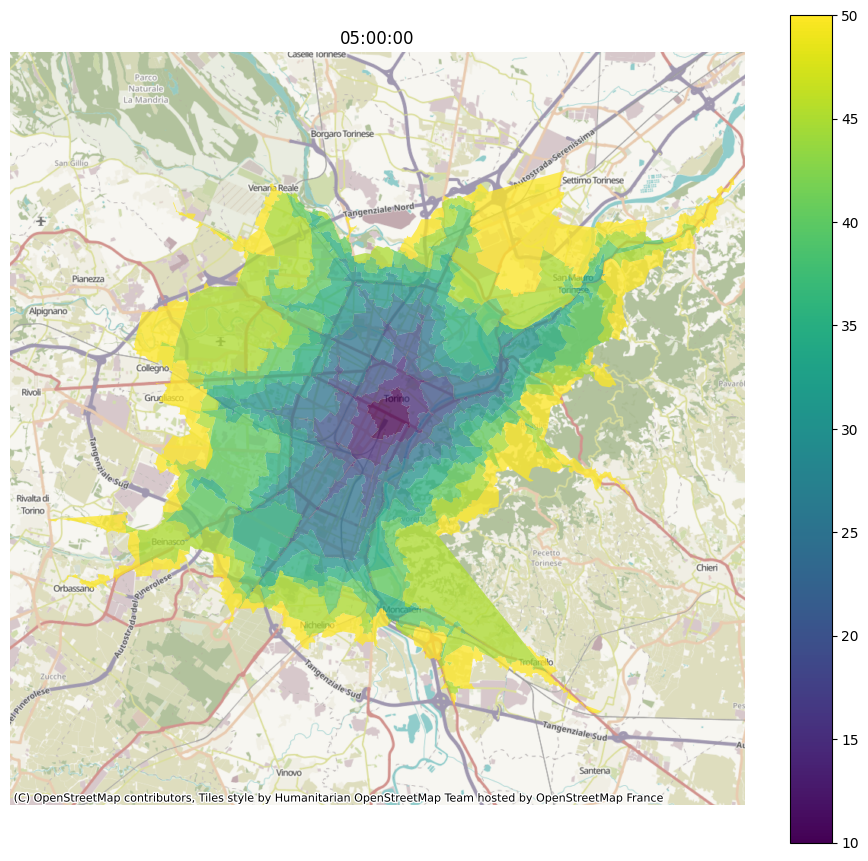

In [293]:
f,ax = plt.subplots(figsize=(12,8.7))

todraw_first=[True]
def plot_frame(i):
    ax.clear()
    print(i)
    df=all_isochrones_cut[i]
    df.plot(column="mins",alpha=0.75, ax=ax,vmin=10,vmax=50, cmap="viridis", legend=todraw_first[0])

    ax.set_ylim(bounds_y)
    ax.set_xlim(bounds_x)
    ax.set_title(str(all_times[i]))
    ax.axis("off")
    plt.subplots_adjust()

    cx.add_basemap(ax, crs=df.crs)
    todraw_first[0]=False

    f.set_tight_layout({'pad':0.5})
    tightbbox = f.get_tightbbox(f.canvas.get_renderer())
    # just set it directly to figure size
    f.set(figheight=tightbbox.height,figwidth=tightbbox.width) 

ani = FuncAnimation(f, plot_frame, frames=len(all_isochrones_cut),
                    interval=800, repeat=False)

# Save the animation as an animated GIF
ani.save("video_long.mp4", dpi=200,
         writer=FFMpegWriter(fps=1,) )#codec="vp8"))

In [296]:

def plot_frame(i):
    ax.clear()
    print(i)
    df=all_isochrones_cut[i]
    df.plot(column="mins",alpha=0.75, ax=ax,vmin=10,vmax=50, cmap="viridis", legend=todraw_first[0])

    ax.set_ylim(bounds_y)
    ax.set_xlim(bounds_x)
    ax.set_title(str(all_times[i]))
    ax.axis("off")
    plt.subplots_adjust()

    cx.add_basemap(ax, crs=df.crs)
    todraw_first[0]=False

    f.set_tight_layout({'pad':0.5})
    tightbbox = f.get_tightbbox(f.canvas.get_renderer())
    # just set it directly to figure size
    f.set(figheight=tightbbox.height,figwidth=tightbbox.width) 
for i in range(len(all_isochrones_cut)):
    f,ax = plt.subplots(figsize=(12,8.6))

    todraw_first=[True]
    plot_frame(i)
    f.savefig(f"isochrone_{place}_{str(START_DATE)}_{str(all_times[i])}.png",dpi=200,bbox_inches="tight")

    plt.close(f)
#ani = FuncAnimation(f, plot_frame, frames=len(all_isochrones_cut),interval=800, repeat=False)

# Save the animation as an animated GIF
#ani.save("video_long.mp4", dpi=200,
#         writer=FFMpegWriter(fps=1,) )#codec="vp8"))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [ ]:
f.set_tight_layout()

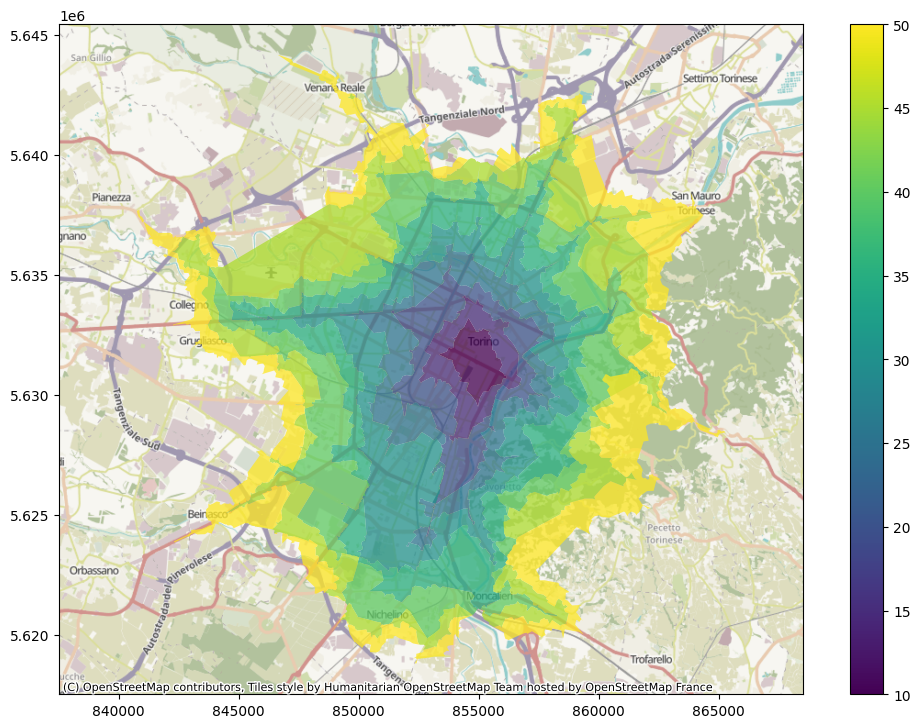

In [227]:
ax=dfnew.plot(column="mins",alpha=0.75, figsize=(12,8.7),vmin=10,vmax=50, cmap="viridis", legend=True)
plt.ylim(bounds_y)
plt.xlim(bounds_x)
ax.axis("equal")
cx.add_basemap(ax, crs=dfnew.crs)


In [224]:
WEB_MERCATOR

'EPSG:3857'

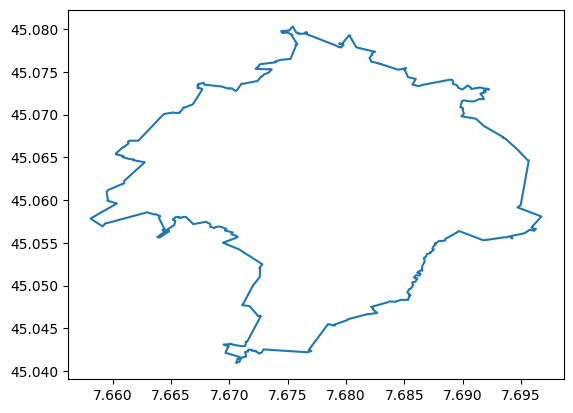

In [144]:
ex = pdff.exterior
plt.plot(*ex.xy)

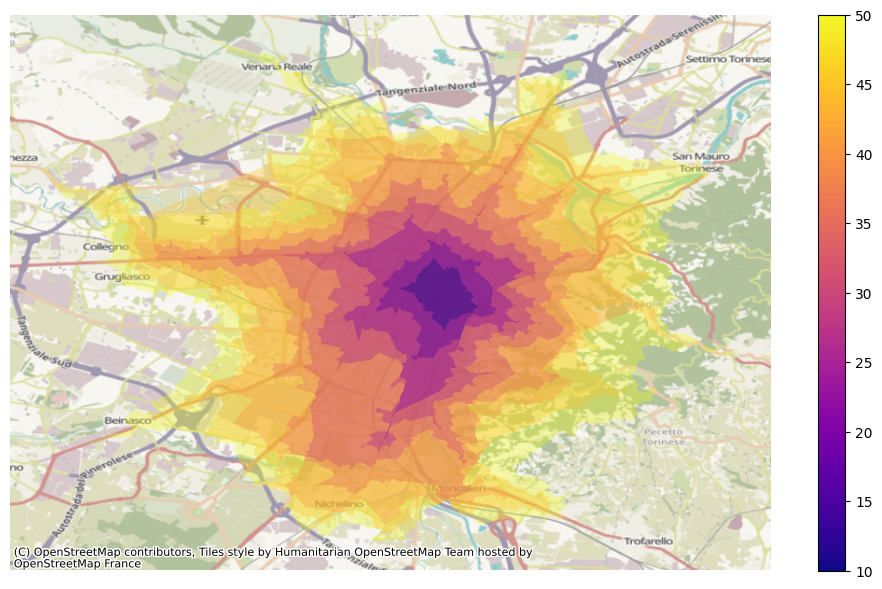

In [133]:

ax=dfplot.plot(column="mins",alpha=0.35, figsize=(9.8,6),vmin=10, legend=True, cmap="plasma")

ax.set_aspect("equal")
cx.add_basemap(ax, crs=dfplot.crs)
ax.axis("off")
plt.tight_layout()
#plt.legend(loc="lower left")

#plt.savefig(f"isochrones_times_{place}_{str(START_DATE)}_{str(START_TIME)}.png",dpi=200,bbox_inches="tight")


In [ ]:
fd